# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [234]:
# import libraries
%matplotlib inline
import os
import pickle
import random
import csv
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
sns.set()

---
## Step 0: Load The Data

In [2]:
# Load pickled data

def load_pickle(file_path):
    with open(file_path, mode='rb') as f:
        return pickle.load(f)
    
# assume the work directory is CarND-Traffic-Sign-Classifier-Project
data_path = os.path.abspath('traffic-signs-data')
signnames_path = os.path.abspath('signnames.csv')

training_file = data_path + '/train.p'
validating_file = data_path + '/valid.p'
testing_file = data_path + '/test.p'

train = load_pickle(training_file)
valid = load_pickle(validating_file)
test = load_pickle(testing_file)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# load sign <=> name mapping. This is only for data exploration
signnames = {}
with open(signnames_path) as f:
    reader = csv.DictReader(f)
    for row in reader:
        signnames[int(row['ClassId'])]  = row['SignName']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Number of examples
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape
n_channels = image_shape[-1]

# How many unique classes/labels there are in the dataset.
y_combined = [y_train, y_valid, y_test]
n_classes = len(set(x for y in y_combined for x in y))

print("Number of training examples =", n_train)
print("Number of validating examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of channels =", n_channels)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of channels = 3
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
def plot_image(image):
    plt.imshow(image)
    
def plot_hist(dataset, title='Histogram'):
    plt.hist(dataset, bins=np.arange(n_classes))
    plt.title(title)
    
def show_image_samples(imageset, labelset):
    fig = plt.figure(figsize=(18,18))
    for i in range(25):
        a = fig.add_subplot(5,5,i+1)
        index = random.randint(0, len(imageset))
        plot_image(imageset[index].squeeze())
        a.set_title(signnames[labelset[index]])

def show_label_distrbution(training_lables, validation_labels, testing_labels):
    fig = plt.figure()
    a = fig.add_subplot(2,2,1)
    plot_hist(np.concatenate([training_lables, validation_labels, testing_labels]), title="All labels distribution")
    b = fig.add_subplot(2,2,2)
    plot_hist(training_lables, title="Training labels distribution")
    c = fig.add_subplot(2,2,3)
    plot_hist(validation_labels, title="Validatting labels distribution")
    d = fig.add_subplot(2,2,4)
    plot_hist(testing_labels, title="Testing labels distribution")

### training samples

In [ ]:
show_image_samples(X_train, y_train)

In [ ]:
show_label_distrbution(y_train, y_valid, y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def rgb2y(img):
    """
    extract Y' channel from RGB channels
    """
    return 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]

def decolorize(dataset, algorithm):
    after = []
    for e in dataset:
        after.append(algorithm(e).reshape(32,32,1))
    return np.array(after)

def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    return 0.1 + 0.8 * image_data / 255

In [ ]:
# X_train = decolorize(X_train, rgb2y)
# X_valid = decolorize(X_valid, rgb2y)
# X_test = decolorize(X_test, rgb2y)
# n_channels = 1

In [7]:
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [ ]:
# X_train = proprocess(X_train, rgb2y)
# X_valid = proprocess(X_valid, rgb2y)
# X_test = proprocess(X_test, rgb2y)
# n_channels = 1

X_train_valid = np.concatenate([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid])
y_all = np.concatenate([y_train_valid, y_test])

X_train_valid = normalize(X_train_valid)
X_test = normalize(X_test)

X_train_valid, y_train_valid = shuffle(X_train_valid, y_train_valid)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    test_size=0.11)

In [ ]:
show_label_distrbution(y_train, y_valid, y_test)

### Model Architecture

In [ ]:
### This is the same model fro LeNet Lab. This yields a validation accuracy of 91%
def LeNet5(x):    
    # Arguments used for tf.truncated_normal
    # randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. 32x32x3 => 28x28x6.
    L1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    L1_b = tf.Variable(tf.zeros(6))
    L1_conv = tf.nn.conv2d(x, L1_W, [1, 1, 1, 1], 'VALID') + L1_b
    
    # Activation.
    L1_act = tf.nn.relu(L1_conv)
    
    # Pooling. 28x28x6 => 14x14x6.
    L1_out = tf.nn.avg_pool(L1_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Layer 2: Convolutional. 14x14x6 => 10x10x16.
    L2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    L2_b = tf.Variable(tf.zeros(16))
    L2_conv = tf.nn.conv2d(L1_out, L2_W, [1, 1, 1, 1], 'VALID') + L2_b
    
    # Activation.
    L2_act = tf.nn.relu(L2_conv)
    
    # Pooling. 10x10x16 => 5x5x16.
    L2_pool = tf.nn.avg_pool(L2_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Flatten. 5x5x16 => Output = 400.
    L2_out = tf.contrib.layers.flatten(L2_pool)
    
    # Layer 3: Fully Connected. 400 => 120.
    L3_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    L3_biases = tf.Variable(tf.zeros(120))
    L3_linear = tf.matmul(L2_out, L3_weights) + L3_biases
    
    # Activation.
    L3_out = tf.nn.relu(L3_linear)
    
    # Layer 4: Fully Connected. 120 => 84.
    L4_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    L4_biases = tf.Variable(tf.zeros(84))
    L4_linear = tf.matmul(L3_out, L4_weights) + L4_biases
    
    # Activation.
    L4_out = tf.nn.relu(L4_linear)
    
    # Layer 5: Fully Connected. 84 => 43.
    L5_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    L5_biases = tf.Variable(tf.zeros(43))
    logits = tf.matmul(L4_out, L5_weights) + L5_biases
    
    return logits

In [8]:
### LeNet + Dropout
def LeNet5do(x, keep_prob):    
    # Arguments used for tf.truncated_normal
    # randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. 32x32x3 => 28x28x6.
    L1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    L1_b = tf.Variable(tf.zeros(6))
    L1_conv = tf.nn.conv2d(x, L1_W, [1, 1, 1, 1], 'VALID') + L1_b
    
    # Activation.
    L1_act = tf.nn.relu(L1_conv)
    
    # Pooling. 28x28x6 => 14x14x6.
    L1_out = tf.nn.avg_pool(L1_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Layer 2: Convolutional. 14x14x6 => 10x10x16.
    L2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    L2_b = tf.Variable(tf.zeros(16))
    L2_conv = tf.nn.conv2d(L1_out, L2_W, [1, 1, 1, 1], 'VALID') + L2_b
    
    # Activation.
    L2_act = tf.nn.relu(L2_conv)
    
    # Pooling. 10x10x16 => 5x5x16.
    L2_pool = tf.nn.avg_pool(L2_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Flatten. 5x5x16 => Output = 400.
    L2_out = tf.contrib.layers.flatten(L2_pool)
    
    L2_do = tf.nn.dropout(L2_out, keep_prob)
    
    # Layer 3: Fully Connected. 400 => 120.
    L3_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    L3_biases = tf.Variable(tf.zeros(120))
    L3_linear = tf.matmul(L2_do, L3_weights) + L3_biases
    
    # Activation.
    L3_out = tf.nn.relu(L3_linear)
    
    # Layer 4: Fully Connected. 120 => 84.
    L4_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    L4_biases = tf.Variable(tf.zeros(84))
    L4_linear = tf.matmul(L3_out, L4_weights) + L4_biases
    
    # Activation.
    L4_out = tf.nn.relu(L4_linear)
    
    # Layer 5: Fully Connected. 84 => 43.
    L5_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    L5_biases = tf.Variable(tf.zeros(43))
    logits = tf.matmul(L4_out, L5_weights) + L5_biases
    
    return logits

In [ ]:
## WIP
def net3(x, n_channels, n_classes):    
    # Arguments used for tf.truncated_normal
    # randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. 32x32x3 => 32x32x12.
    L1_k = 12
    L1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, n_channels, L1_k), mean=mu, stddev=sigma))
    L1_b = tf.Variable(tf.zeros(L1_k))
    L1_conv = tf.nn.conv2d(x, L1_W, [1, 1, 1, 1], 'SAME') + L1_b
    
    # Activation.
    L1_act = tf.nn.relu(L1_conv)
    
    # Pooling. 32x32x12 => 16x16x12.
    L1_out = tf.nn.avg_pool(L1_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Layer 2: Convolutional. 16x16x12 => 14x14x16.
    L2_k = 6
    L2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, L1_k, L2_k), mean=mu, stddev=sigma))
    L2_b = tf.Variable(tf.zeros(L2_k))
    L2_conv = tf.nn.conv2d(L1_out, L2_W, [1, 1, 1, 1], 'VALID') + L2_b
    
    # Activation.
    L2_act = tf.nn.relu(L2_conv)
    
    # Pooling. 14x14x6 => 7x7x6.
    L2_pool = tf.nn.avg_pool(L2_act, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Flatten. 7x7x6 => Output = 294.
    L2_out = tf.contrib.layers.flatten(L2_pool)
    
    # Layer 3: Fully Connected. 576 => 43.
    L3_weights = tf.Variable(tf.truncated_normal(shape=(294, 43), mean=mu, stddev=sigma))
    L3_biases = tf.Variable(tf.zeros(43))
    logits = tf.matmul(L2_out, L3_weights) + L3_biases
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [157]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 128
LR = 0.001
KEEP_PROD = 0.5

In [158]:
x = tf.placeholder(tf.float32, (None, 32, 32, n_channels))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
logits = LeNet5do(x, keep_prob)
softmax = tf.nn.softmax(logits)
prediction = tf.argmax(softmax, 1)

In [159]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LR)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = LR)
training_operation = optimizer.minimize(loss_operation)

In [160]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training and Validation

In [161]:
### DO NOT MODIFY THIS SECTION
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROD})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.569

EPOCH 2 ...
Validation Accuracy = 0.759

EPOCH 3 ...
Validation Accuracy = 0.820

EPOCH 4 ...
Validation Accuracy = 0.843

EPOCH 5 ...
Validation Accuracy = 0.859

EPOCH 6 ...
Validation Accuracy = 0.880

EPOCH 7 ...
Validation Accuracy = 0.895

EPOCH 8 ...
Validation Accuracy = 0.896

EPOCH 9 ...
Validation Accuracy = 0.910

EPOCH 10 ...
Validation Accuracy = 0.907

EPOCH 11 ...
Validation Accuracy = 0.917

EPOCH 12 ...
Validation Accuracy = 0.917

EPOCH 13 ...
Validation Accuracy = 0.926

EPOCH 14 ...
Validation Accuracy = 0.922

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.929

EPOCH 18 ...
Validation Accuracy = 0.939

EPOCH 19 ...
Validation Accuracy = 0.941

EPOCH 20 ...
Validation Accuracy = 0.934

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.950

EPOCH 23 ...
Validation Accuracy = 0.946

EPOCH 24 ...
Validation Accura

### Testing

In [162]:
### DO NOT MODIFY THIS SECTION
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.940


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [310]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
def predict(image):
    '''
    predict single image
    input: normalized image in format (32, 32, 3)
    output: the index of the class
    '''
    image_reshaped = image.reshape(1, 32, 32, 3)

    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        
        pred, = sess.run(prediction, feed_dict={x: image_reshaped, keep_prob: 1})
        return pred

In [311]:
def predict_image(image):
    #plot_image(image)
    
    normalized_image = normalize(image)
    predicted_class = predict(normalized_image)
    predicted_description = signnames[predicted_class]
    return predicted_description
    #print ("predicted class: {} ({})".format(predicted_class, predicted_description))


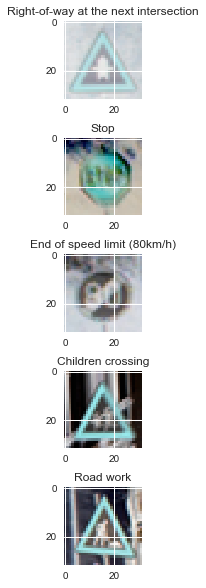

In [313]:
def get_test_image(id):
    image = Image.open(data_path + "/test_images/" + str(id) + ".ppm")
    image = image.resize([32, 32], Image.ANTIALIAS)
    test_image = np.array(image, dtype=np.float32)
    return test_image

# images are downloaded and saved under /test_images
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=.5)
for i in range(5):
    test_image = get_test_image(i+1)
    description = predict_image(test_image)
    f = fig.add_subplot(5, 1, i + 1)
    f.set_title(description)
    plt.imshow(test_image)
    

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [122]:
with tf.Session() as sess:
    pr = tf.placeholder(tf.float32)
    pmax = tf.argmax(pr, 1)
    output = sess.run(pmax, feed_dict={pr: p})
    print(output)

[5]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [316]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def top_n(image, n=3):
    '''
    predict single image
    input: normalized image in format (32, 32, 3)
    output: the index of the class
    '''
    image_reshaped = image.reshape(1, 32, 32, 3)
    top3 = tf.nn.top_k(softmax, k=n)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        top_n_prob = sess.run(top3, feed_dict={x: image_reshaped, keep_prob: 1})
        return top_n_prob

In [321]:
test_image = get_test_image(3)
test_image = normalize(test_image)
p = top_n(test_image)

In [324]:
p.values
p.indices

array([[ 6, 42,  5]], dtype=int32)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
outputFeatureMap(test_image, con

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 